## Simple training

In [1]:
import sys
sys.path.append("../src")

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, SAGEConv

%load_ext autoreload
%autoreload 2

from data import *
from loader import *
from model import *

import matplotlib.pyplot as plt
import pickle
import random
from scipy.stats import binned_statistic, median_abs_deviation
import time

device = "cuda"


In [25]:
def train(dataloader, model, optimizer, device="cuda"):

    model.train()

    loss_total = 0
    for data in dataloader:
        data.to(device)       
        
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    return loss_total / len(dataloader)

def validate(dataloader, model, device="cuda"):
    model.eval()

    uncertainties = []
    loss_total = 0

    y_preds = []
    y_trues = []

    for data in dataloader:
        data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            loss = F.mse_loss(y_pred, data.y)

            loss_total += loss.item()
            y_preds += list(y_pred.detach().cpu().numpy())
            y_trues += list(data.y.detach().cpu().numpy())

    y_preds = np.array(y_preds)
    y_trues = np.array(y_trues)

    return (
        loss_total / len(dataloader),
        y_preds,
        y_trues,
    )

## make data

In [2]:
if not os.path.exists("merger_trees.pkl"):
    subhalos = prepare_subhalos()
    trees = load_trees()

    merger_trees = make_merger_tree_graphs(trees, subhalos)

    with open('merger_trees.pkl', 'wb') as f:
        pickle.dump(merger_trees, f)

In [3]:
with open("merger_trees.pkl", "rb") as f:
    trees = pickle.load(f)

print(len(trees))

111197


## load and look at data

Text(0, 0.5, 'Frequency')

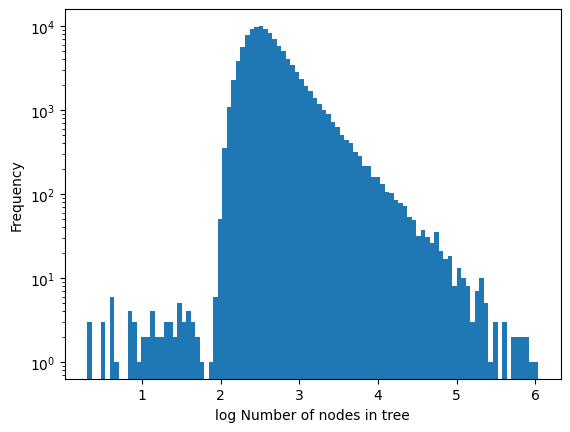

In [4]:
n_nodes = [d.x.size(0) for d in trees]
plt.hist(np.log10(n_nodes), log=True, bins=100)
plt.xlabel("log Number of nodes in tree")
plt.ylabel("Frequency")

In [5]:
# examine trees with > 10^5 nodes
tree_stats = pd.DataFrame({
    "n_nodes": n_nodes,
    "stellar_mass": [d.y.item() for d in trees],
    "peak_halo_mass": [d.x[:, 0].max().item() for d in trees],
    "peak_vmax": [d.x[:, 1].max().item() for d in trees],
})

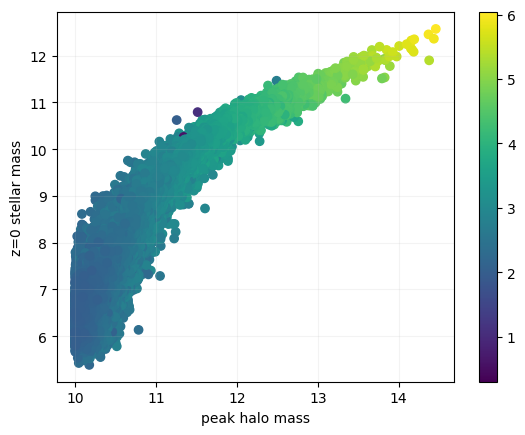

In [6]:
plt.scatter(
    tree_stats.peak_halo_mass,
    tree_stats.stellar_mass,
    c=tree_stats.n_nodes.apply(np.log10)
)

plt.ylabel("z=0 stellar mass")
plt.xlabel("peak halo mass")

plt.colorbar()
plt.grid(alpha=0.15)

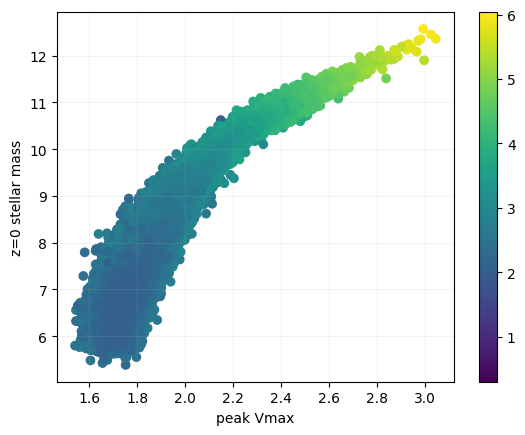

In [7]:
plt.scatter(
    tree_stats.peak_vmax,
    tree_stats.stellar_mass,
    c=tree_stats.n_nodes.apply(np.log10)
)

plt.ylabel("z=0 stellar mass")
plt.xlabel("peak Vmax")

plt.colorbar()
plt.grid(alpha=0.15)

In [8]:
trees[999]

Data(x=[428, 9], edge_index=[2, 427], y=[1], root_subhalo_id=24980)

## Set up model

In [9]:
class SAGEGraphConvNet(torch.nn.Module):
    """A simple GNN built using SAGEConv layers.

    Makes full graph-level predictions (i.e. one for each merger tree)
    """
    def __init__(self, n_in=4, n_hidden=16, n_out=1, aggr="max"):
        super(SAGEGraphConvNet, self).__init__()
        self.conv1 = SAGEConv(n_in, n_hidden, aggr=aggr)
        self.conv2 = SAGEConv(n_hidden, n_hidden, aggr=aggr)
        self.mlp = nn.Sequential(
            nn.Linear(n_in + 2 * n_hidden, n_hidden, bias=True),
            nn.SiLU(),
            nn.LayerNorm(n_hidden),
            nn.Linear(n_hidden, n_hidden, bias=True)
        )
        self.readout = nn.Linear(2 * n_hidden, n_out, bias=True)

    def forward(self, data):
        x0, edge_index = data.x, data.edge_index

        x1 = self.conv1(x0, edge_index)
        x2 = self.conv2(F.silu(x1), edge_index)
        out = self.mlp(torch.cat([F.silu(x2), F.silu(x1), x0], dim=-1))

        out = torch.cat([
            global_mean_pool(out, data.batch),
            global_max_pool(out, data.batch), 
            # global_add_pool(out, data.batch)
        ], axis=1)
        # out = global_mean_pool(out, data.batch)
        
        return self.readout(out)[:, 0]

In [14]:
model = SAGEGraphConvNet(n_in=9).to(device)
model

SAGEGraphConvNet(
  (conv1): SAGEConv(9, 16, aggr=max)
  (conv2): SAGEConv(16, 16, aggr=max)
  (mlp): Sequential(
    (0): Linear(in_features=41, out_features=16, bias=True)
    (1): SiLU()
    (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
  )
  (readout): Linear(in_features=32, out_features=1, bias=True)
)

In [15]:
random.shuffle(trees)

In [16]:
trees[999]

Data(x=[339, 9], edge_index=[2, 338], y=[1], root_subhalo_id=969120)

In [17]:
model(trees[999].to(device))

tensor([-0.0998], device='cuda:0', grad_fn=<SelectBackward0>)

In [18]:

train_loader = DataLoader(trees[:88888], batch_size=32, shuffle=True)
valid_loader = DataLoader(trees[88888:], batch_size=32, shuffle=False)

In [19]:
xb = next(iter(train_loader))
xb.to(device)
y_pred = model(xb)
y_pred

tensor([ 0.1138, -0.0529, -0.0587, -0.0993, -0.1024, -0.0454, -0.0819, -0.0913,
        -0.0759, -0.1031, -0.0808, -0.1127, -0.0935, -0.0024, -0.0989, -0.0319,
        -0.0896,  0.0782, -0.0724, -0.0225, -0.1068, -0.0662, -0.0822,  0.0661,
         0.0396, -0.1116, -0.1117,  0.0356,  0.0235, -0.1176, -0.1240, -0.0420],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [20]:
xb.y

tensor([10.9956,  7.5424,  8.8956,  7.4773,  7.6359,  9.1339,  7.0106,  6.9096,
         6.7223,  7.7848,  7.6881,  8.2434,  7.3095,  9.7895,  6.1817,  8.0881,
         7.1100, 10.4009,  6.9853,  8.3530,  7.1327,  6.3094,  6.9850, 10.0030,
         9.1735,  7.9827,  8.7024,  9.5817,  8.3724,  7.9307,  8.1106,  6.7572],
       device='cuda:0')

In [21]:
F.mse_loss(y_pred, xb.y)

tensor(66.8188, device='cuda:0', grad_fn=<MseLossBackward0>)

## Reload everything cleanly

In [22]:
with open("merger_trees.pkl", "rb") as f:
    trees = pickle.load(f)

random.shuffle(trees)

batch_size = 128

train_loader = DataLoader(trees[:88888], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(trees[88888:], batch_size=batch_size, shuffle=False)

In [23]:
model = SAGEGraphConvNet(n_in=9, Tuesday n_hidden=32, aggr="max")
model.to(device)

SAGEGraphConvNet(
  (conv1): SAGEConv(9, 32, aggr=max)
  (conv2): SAGEConv(32, 32, aggr=max)
  (mlp): Sequential(
    (0): Linear(in_features=73, out_features=32, bias=True)
    (1): SiLU()
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (readout): Linear(in_features=64, out_features=1, bias=True)
)

In [26]:
train_losses = []
valid_losses = []

n_epochs = 100

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

print(f"Epoch    Train loss   Valid Loss      RSME ")
for epoch in range(n_epochs):

    train_loss = train(train_loader, model, optimizer, device=device)
    valid_loss, p, y  = validate(valid_loader, model, device=device)

    print(f" {epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch    Train loss   Valid Loss      RSME 
    1      1.34854      0.18696      0.432609
    2      0.18148      0.16287      0.403712
    3      0.16143      0.14931      0.386494
    4      0.15174      0.14062      0.375152
    5      0.14488      0.13639      0.369434
    6      0.13963      0.12991      0.360641
    7      0.13443      0.13454      0.366843
    8      0.13071      0.12168      0.349012
    9      0.12692      0.11996      0.346512
   10      0.12411      0.11840      0.344293
   11      0.12202      0.12877      0.359116
   12      0.11952      0.11598      0.340750
   13      0.11759      0.11730      0.342710
   14      0.11585      0.11378      0.337517
   15      0.11543      0.11106      0.333484
   16      0.11470      0.12290      0.350730
   17      0.11475      0.10989      0.331682
   18      0.11346      0.11528      0.339701
   19      0.11204      0.11166      0.334411
   20      0.11255      0.11125      0.333759
   21      0.11229      0.10808     

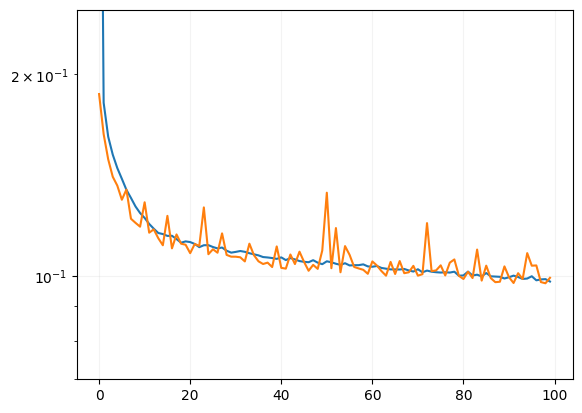

In [27]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.ylim(0.07, 0.25)
plt.yscale("log");
plt.grid(alpha=0.15)

In [28]:
valid_loss, p, y  = validate(valid_loader, model, device=device)

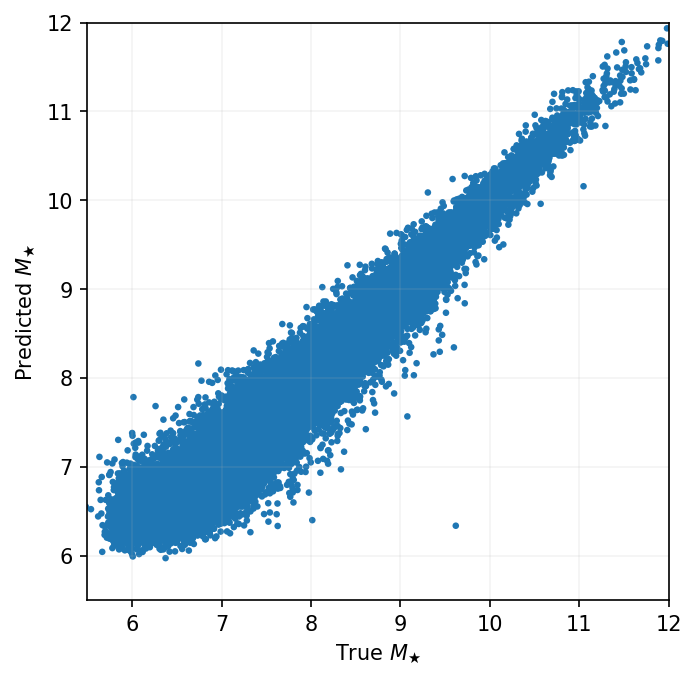

In [29]:
plt.figure(figsize=(5,5), dpi=150)
plt.scatter(y, p, s=10, edgecolors="none", )
plt.xlabel(r"True $M_{\bigstar}$")
plt.ylabel(r"Predicted $M_{\bigstar}$")
plt.grid(alpha=0.15)
plt.xlim(5.5, 12)
plt.ylim(5.5, 12)
plt.show()

## More training

In [ ]:
# train a bit more at lower lr and wd

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-7
)

print(f"Epoch    Train loss   Valid Loss      RSME ")
for epoch in range(20):

    train_loss = train(train_loader, model, optimizer, device=device)
    valid_loss, p, y  = validate(valid_loader, model, device=device)

    print(f" {epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

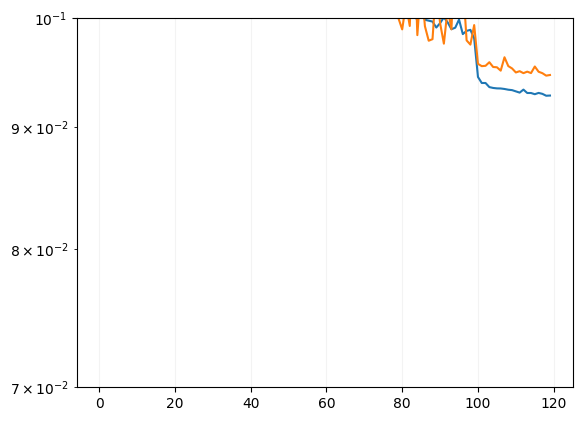

In [31]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.ylim(0.07, 0.1)
plt.yscale("log");
plt.grid(alpha=0.15)

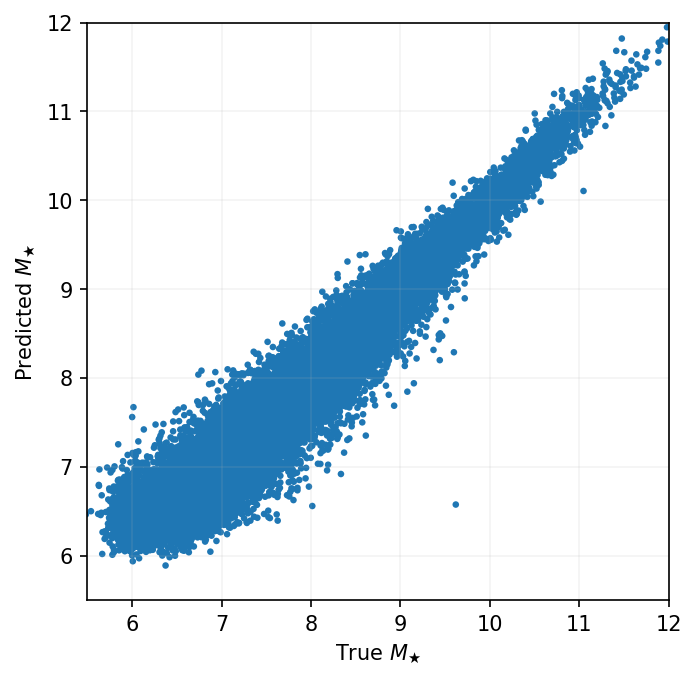

In [32]:
valid_loss, p, y  = validate(valid_loader, model, device=device)

plt.figure(figsize=(5,5), dpi=150)
plt.scatter(y, p, s=10, edgecolors="none", )
plt.xlabel(r"True $M_{\bigstar}$")
plt.ylabel(r"Predicted $M_{\bigstar}$")
plt.grid(alpha=0.15)
plt.xlim(5.5, 12)
plt.ylim(5.5, 12)
plt.show()

## train deeper model

In [34]:
with open("merger_trees.pkl", "rb") as f:
    trees = pickle.load(f)

random.shuffle(trees)

batch_size = 128

train_loader = DataLoader(trees[:88888], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(trees[88888:], batch_size=batch_size, shuffle=False)

In [51]:
class MultiSAGENet(torch.nn.Module):
    """A multi-layer GNN built using SAGEConv layers.

    Makes full graph-level predictions (i.e. one for each merger tree)
    """
    def __init__(
        self, 
        n_in=4, 
        n_hidden=16, 
        n_out=1, 
        n_layers=4, 
        aggr=["max", "mean"]
    ):
        super(MultiSAGENet, self).__init__()

        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.n_layers = n_layers
        self.aggr = aggr

        sage_convs = [SAGEConv(self.n_in, self.n_hidden, aggr=self.aggr)]                
        sage_convs += [SAGEConv(self.n_hidden, self.n_hidden, aggr=self.aggr) for _ in range(self.n_layers - 1)]
        self.convs = nn.ModuleList(sage_convs)
        
        self.mlp = nn.Sequential(
            nn.Linear(self.n_hidden, 4 * self.n_hidden, bias=True),
            nn.SiLU(),
            nn.LayerNorm(4 * self.n_hidden),
            nn.Linear(4 * self.n_hidden, self.n_hidden, bias=True)
        )
        self.readout = nn.Sequential(
            nn.Linear(3 * self.n_hidden, 4 * self.n_hidden, bias=True),
            nn.SiLU(),
            nn.LayerNorm(4 * self.n_hidden),
            nn.Linear(4 * self.n_hidden, 2 * self.n_out, bias=True)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.silu(x)

        x = self.mlp(x)
 
        out = torch.cat([
            global_mean_pool(x, data.batch),
            global_max_pool(x, data.batch), 
            global_add_pool(x, data.batch)
        ], axis=1)
              
        return self.readout(out)

In [52]:
model = MultiSAGENet(n_in=9, n_hidden=8, n_layers=8, n_out=1).to(device)
model

MultiSAGENet(
  (convs): ModuleList(
    (0): SAGEConv(9, 8, aggr=['max', 'mean'])
    (1-7): 7 x SAGEConv(8, 8, aggr=['max', 'mean'])
  )
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): SiLU()
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=32, out_features=8, bias=True)
  )
  (readout): Sequential(
    (0): Linear(in_features=24, out_features=32, bias=True)
    (1): SiLU()
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [53]:
def train(dataloader, model, optimizer, device="cuda", augment_noise=True):
    """Train GNN model using Gaussian NLL loss."""
    model.train()

    loss_total = 0
    for data in (dataloader):
        if augment_noise: 
            # add random noise to halo mass and vmax
            data_node_features_scatter = 3e-4 * torch.randn_like(data.x[:, :2]) * torch.std(data.x[:, :2], dim=0)
            data.x[:, :2] += data_node_features_scatter
            assert not torch.isnan(data.x).any() 

        data.to(device)

        optimizer.zero_grad()
        y_pred, logvar_pred = model(data).chunk(2, dim=1)
        assert not torch.isnan(y_pred).any() and not torch.isnan(logvar_pred).any()

        y_pred = y_pred.view(-1, model.n_out)
        logvar_pred = logvar_pred.mean()
        loss = 0.5 * (F.mse_loss(y_pred.view(-1), data.y) / 10**logvar_pred + logvar_pred)

        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    return loss_total / len(dataloader)


def validate(dataloader, model, device="cuda"):
    model.eval()

    loss_total = 0

    y_preds = []
    y_trues = []
    subhalo_ids = []

    for data in (dataloader):
        with torch.no_grad():
            data.to(device)
            y_pred, logvar_pred = model(data).chunk(2, dim=1)
            y_pred = y_pred.view(-1, model.n_out)
            logvar_pred = logvar_pred.mean()
            loss = 0.5 * (F.mse_loss(y_pred.view(-1), data.y) / 10**logvar_pred + logvar_pred)

            loss_total += loss.item()
            y_preds += list(y_pred.detach().cpu().numpy())
            y_trues += list(data.y.detach().cpu().numpy())

    y_preds = np.concatenate(y_preds)
    y_trues = np.array(y_trues)
    subhalo_ids = np.array(subhalo_ids)

    return (
        loss_total / len(dataloader),
        y_preds,
        y_trues,
    )

In [54]:
train_losses = []
valid_losses = []

n_epochs = 100

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

print(f"Epoch    Train loss   Valid Loss      RSME ")
for epoch in range(n_epochs):

    t0 = time.time()

    train_loss = train(train_loader, model, optimizer, device=device)
    valid_loss, p, y  = validate(valid_loader, model, device=device)

    t1 = time.time()

    print(f" {epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}    {t1-t0:.1f}s")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch    Train loss   Valid Loss      RSME 
    1      1.49965      0.28611      0.756700    11.5s
    2      0.11000      0.03231      0.430179    11.6s
    3      0.02339      0.03034      0.428208    11.5s
    4     -0.00472     -0.02858      0.371885    11.5s
    5      0.00328     -0.01115      0.388090    11.6s
    6     -0.02940     -0.06811      0.341356    11.6s
    7     -0.05284     -0.04755      0.347539    11.6s
    8     -0.07984     -0.09107      0.323189    11.6s
    9     -0.08365     -0.05676      0.348891    11.6s
   10     -0.07530     -0.10156      0.315705    11.6s
   11     -0.09116     -0.08109      0.331401    11.6s
   12     -0.09835     -0.11164      0.308864    11.6s
   13     -0.10607     -0.08418      0.328290    11.6s
   14     -0.09200     -0.10545      0.312963    11.6s
   15     -0.10634     -0.09917      0.316784    11.6s
   16     -0.11282     -0.04613      0.356615    11.7s
   17     -0.10911     -0.12054      0.302455    11.7s
   18     -0.11319   

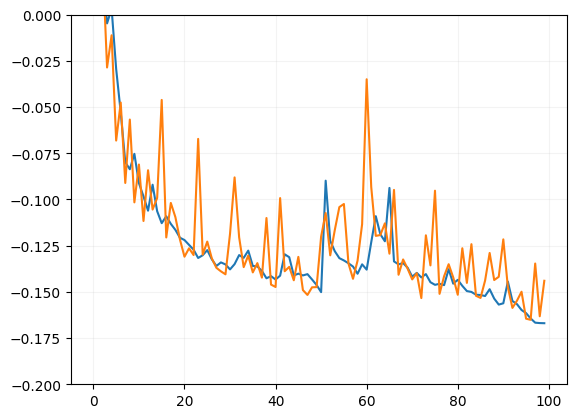

In [55]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.ylim(-0.2, 0)
plt.grid(alpha=0.15)

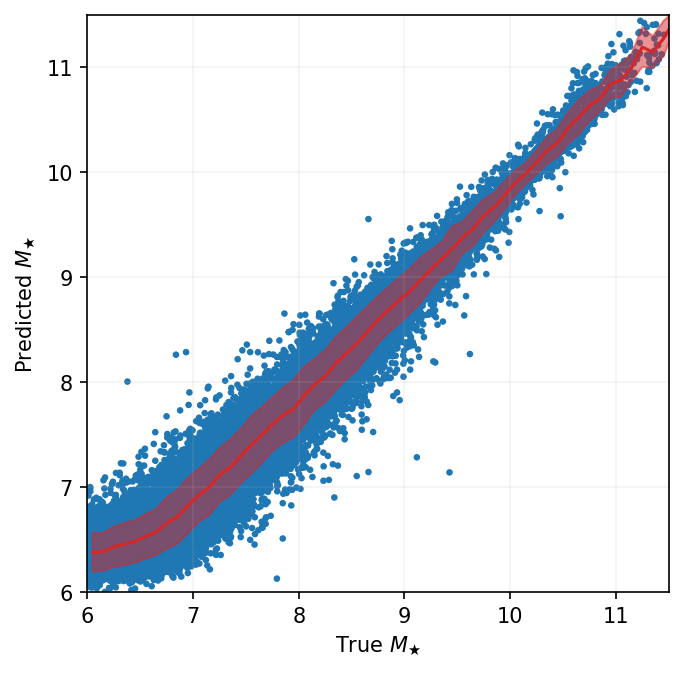

In [56]:
valid_loss, p, y  = validate(valid_loader, model, device=device)

bin_edges = np.arange(6., 12.5, 0.1)
means, *_ = binned_statistic(y, p, statistic="mean", bins=bin_edges)
stds, *_ = binned_statistic(y, p, statistic="std", bins=bin_edges)

plt.figure(figsize=(5,5), dpi=150)
plt.scatter(y, p, s=10, edgecolors="none", )
plt.plot(bin_edges[:-1]+0.05, means, c="C3")
plt.fill_between(bin_edges[:-1]+0.05, means-stds, means+stds, color="C3", alpha=0.5)
plt.xlabel(r"True $M_{\bigstar}$")
plt.ylabel(r"Predicted $M_{\bigstar}$")
plt.grid(alpha=0.15)
plt.xlim(6, 11.5)
plt.ylim(6, 11.5)
plt.show()

In [57]:
def compute_metrics(p, y):
    nmad = median_abs_deviation((p-y), scale="normal")    
    std = np.std(p - y)
    bias = np.mean(p - y)
    f_outlier = np.mean(np.absolute(p-y) > 3*nmad)

    return nmad, std, bias, f_outlier

In [58]:
nmad, std, bias, f_outlier = compute_metrics(p, y)

print(f"  NMAD scatter     = {nmad:.3f} dex")
print(f"  stdev scatter    = {std:.3f} dex")
print(f"  bias             = {bias:.3f} dex")
print(f"  outlier fraction = {100*f_outlier:.3f}%")

  NMAD scatter     = 0.244 dex
  stdev scatter    = 0.270 dex
  bias             = -0.096 dex
  outlier fraction = 1.385%


In [59]:
is_high_mass = (y > 8)

p_high_mass = p[is_high_mass]
y_high_mass = y[is_high_mass]

In [60]:
nmad, std, bias, f_outlier = compute_metrics(p_high_mass, y_high_mass.reshape(-1))

print(f"  NMAD scatter     = {nmad:.3f} dex")
print(f"  stdev scatter    = {std:.3f} dex")
print(f"  bias             = {bias:.3f} dex")
print(f"  outlier fraction = {100*f_outlier:.3f}%")

  NMAD scatter     = 0.179 dex
  stdev scatter    = 0.211 dex
  bias             = -0.171 dex
  outlier fraction = 5.146%
